<a href="https://colab.research.google.com/github/Jvlia17/deep-learning/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super().__init__()
        self.inplanes = 16
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(16),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 16, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 32, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 64, layers[2], stride = 2)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = F.avg_pool2d(x, x.size()[3])
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

model = ResNet(ResidualBlock, [18,18,18]).to(device)

summary(model, (3, 32, 32))

# x = torch.randn(1,3,32, 32)
# y = model(x)

# make_dot(y.mean(), params=dict(model.named_parameters())).render("rnn_torchviz", format="png")

In [12]:
# Loading the model

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)
state = torch.load('/content/resnet_cifar10_219.pth', map_location=torch.device('cpu'))
model = ResNet(ResidualBlock, [18,18,18]).to(device)
model.load_state_dict(state['model_state_dict'])
optimizer.load_state_dict(state['optimizer_state_dict'])
model.eval()

print('Acc:', state['accuracy'], '\tLoss: ', state['loss'], '\tAcc test: ', state['test_accuracy'])

Acc: 0.95048 	Loss:  0.13424459638078803 	Acc test:  0.8391


##Trening PCA

In [74]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = models.resnet152(pretrained=True)
modules=list(model.children())[:-2]

print(len(list(model.children())))
print(modules)
print(len(modules))
model=nn.Sequential(*modules).to(device)

model.eval()


normalize= transforms.Normalize(mean=[0.49186882, 0.48265398, 0.44717732], std=[0.24697122, 0.24338895, 0.2615926 ])
batch_size = 128

train_loader = torch.utils.data.DataLoader(
            CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True, pin_memory=True)

counter = 0
features = []
labels = []
with torch.no_grad():
    for (inputs, targets) in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      for i in range(len(targets)):
        labels.append(targets[i].to('cpu'))
      outputs = model(inputs).to(device)
      for i in range(len(outputs)):
        features.append(outputs[i].to('cpu'))
      print('Batch ', counter, '/', len(train_loader))
      counter = counter + 1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


10
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

In [75]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns


features_np = [x.squeeze().numpy() for x in features]
features_np = np.array(features_np)
print(features_np.shape)
labels_np = np.array([y.squeeze().numpy() for y in labels])
print(labels_np)

features = ['Feature' + str(i) for i in range(features_np.shape[1])]
df_cifar = pd.DataFrame(features_np, columns = features)
df_cifar['Label'] = labels_np
print(df_cifar.head())


(50000, 2048)
[1 6 9 ... 1 6 1]
   Feature0  Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  \
0  0.839307       0.0  0.000000       0.0  0.000000   0.00000  1.665039   
1  0.025190       0.0  9.177691       0.0  0.311463   0.46165  0.505060   
2  0.000000       0.0  2.993951       0.0  0.000000   0.00000  0.360629   
3  0.000000       0.0  0.000000       0.0  0.000000   0.00000  0.000000   
4  0.198759       0.0  2.903578       0.0  0.000000   0.00000  0.102975   

   Feature7  Feature8  Feature9  ...  Feature2039  Feature2040  Feature2041  \
0       0.0  0.000000  0.877905  ...     0.000000     0.000000     0.000000   
1       0.0  0.000000  0.000000  ...     0.162628     0.017943     0.000000   
2       0.0  1.378595  0.000000  ...     0.000000     0.000000     0.004243   
3       0.0  0.000000  0.000000  ...     0.030111     0.292551     0.000000   
4       0.0  0.694959  1.728014  ...     0.000000     3.208323     0.264588   

   Feature2042  Feature2043  Feature2044  

Przeprowadzono zmniejszenie wymiarowości obrazów w celu porównania otrzymanych dwuwymiarowych wektrów reprezentujących różne klasy obrazów w przestrzeni cech.
Do zmniejszenia wymiarowości użyto metody PCA (*Principal Component Analysis*).

In [76]:
pca_model = PCA(2)
# apply PCA to each column except the last one (label)
convereted_data = pca_model.fit_transform(df_cifar.iloc[:,:-1])
df_converted_data = pd.DataFrame(data = convereted_data, columns = ['Principal Component 1', 'Principal Component 2'])
df_converted_data['Label'] = labels_np

print(df_converted_data.head())


   Principal Component 1  Principal Component 2  Label
0              -1.367483              10.017731      1
1             -17.237616             -12.542666      6
2              14.011014              22.489155      9
3             -15.497753              -8.084271      5
4              26.378332              -6.393397      9


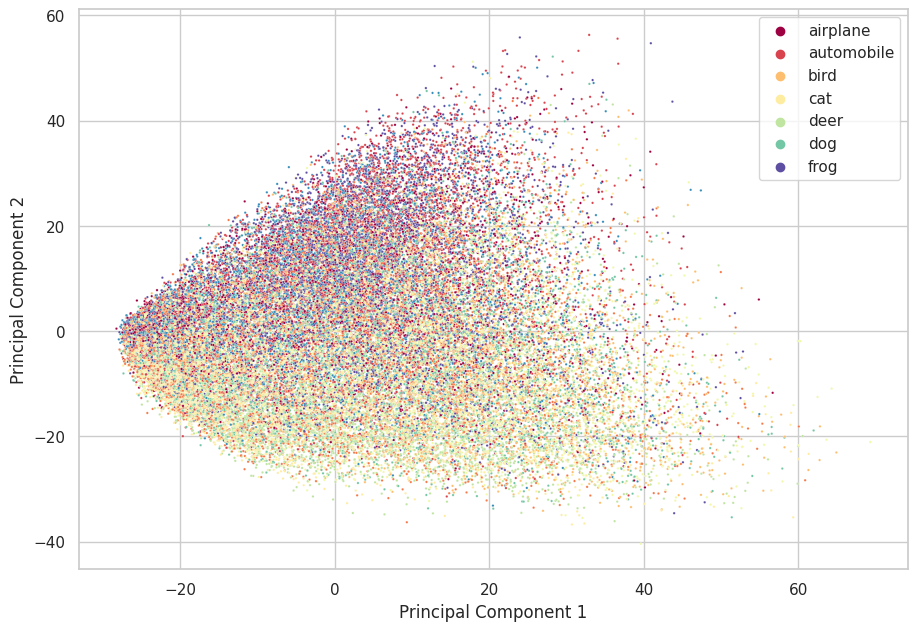

In [77]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.set(rc={'figure.figsize':(10.7,7.27)})
sns.set_style("whitegrid")
g = sns.scatterplot(data=df_converted_data, x="Principal Component 1",
                y="Principal Component 2", hue="Label",
                palette=sns.color_palette("Spectral", as_cmap=True),
                s = 3)

handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, classes, bbox_to_anchor=(1, 1))
plt.savefig("/content/PCA.pdf", format='pdf')

## Zastosowanie PCA

In [ ]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms
# from torchvision.datasets import CIFAR10
# from torchsummary import summary
# import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# model = models.resnet152(pretrained=True)
# modules=list(model.children())[:-2]

# print(len(list(model.children())))
# print(modules)
# print(len(modules))
# model=nn.Sequential(*modules).to(device)

# model.eval()


# normalize= transforms.Normalize(mean=[0.49186882, 0.48265398, 0.44717732], std=[0.24697122, 0.24338895, 0.2615926 ])
# batch_size = 128

test_loader = torch.utils.data.DataLoader(
            CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True, pin_memory=True)

counter = 0
features = []
labels = []
with torch.no_grad():
    for (inputs, targets) in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      for i in range(len(targets)):
        labels.append(targets[i].to('cpu'))
      outputs = model(inputs).to(device)
      for i in range(len(outputs)):
        features.append(outputs[i].to('cpu'))
      print('Batch ', counter, '/', len(train_loader))
      counter = counter + 1

In [79]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns


features_np = [x.squeeze().numpy() for x in features]
features_np = np.array(features_np)
print(features_np.shape)
labels_np = np.array([y.squeeze().numpy() for y in labels])
print(labels_np)

features = ['Feature' + str(i) for i in range(features_np.shape[1])]
df_cifar = pd.DataFrame(features_np, columns = features)
df_cifar['Label'] = labels_np
print(df_cifar.head())


(10000, 2048)
[3 3 8 ... 0 3 2]
   Feature0  Feature1   Feature2  Feature3  Feature4  Feature5  Feature6  \
0  0.000000  0.000000   9.721644  0.000000  0.042597  0.000000  1.225263   
1  0.000000  0.085636   1.741686  1.666414  0.000000  0.000000  3.616848   
2  2.634907  1.355408   0.000000  1.683782  0.371125  0.439137  4.195706   
3  0.000000  0.000000  10.349157  0.000000  0.104123  0.711437  0.000000   
4  0.489347  0.000000   1.630867  0.000000  1.334621  0.000000  1.084976   

   Feature7  Feature8  Feature9  ...  Feature2039  Feature2040  Feature2041  \
0  0.196499  0.000000  0.489149  ...     0.000000     3.864929     2.233742   
1  4.006466  2.222798  0.027844  ...     0.000000     3.787864     2.052811   
2  1.618234  1.334533  0.000000  ...     0.059245     0.000000     0.000000   
3  0.065819  0.774987  0.000000  ...     0.078139     0.065019     0.000000   
4  0.000000  1.183665  0.000000  ...     0.681226     0.699894     0.000000   

   Feature2042  Feature2043  Feature

In [80]:
# apply PCA to each column except the last one (label)
convereted_data = pca_model.transform(df_cifar.iloc[:,:-1])
df_converted_data = pd.DataFrame(data = convereted_data, columns = ['Principal Component 1', 'Principal Component 2'])
df_converted_data['Label'] = labels_np

print(df_converted_data.head())


   Principal Component 1  Principal Component 2  Label
0              20.317822             -18.406578      3
1              27.335062             -13.522870      3
2              -7.917718              15.818585      8
3             -15.185987             -19.585075      4
4              15.417823              19.936920      0


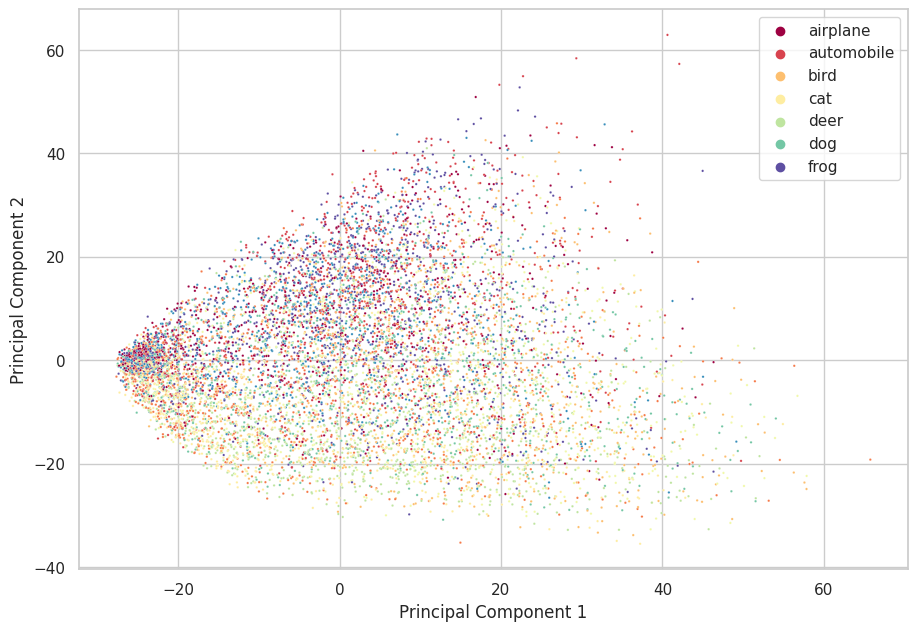

In [81]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.set(rc={'figure.figsize':(10.7,7.27)})
sns.set_style("whitegrid")
g = sns.scatterplot(data=df_converted_data, x="Principal Component 1",
                y="Principal Component 2", hue="Label",
                palette=sns.color_palette("Spectral", as_cmap=True),
                s = 3)

handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, classes, bbox_to_anchor=(1, 1))
plt.savefig("/content/PCA.pdf", format='pdf')

## Porównanie próbki oryginalnej i adwersarzowej

In [ ]:
!pip install torchattacks

In [132]:
import torchattacks
from robustbench.data import load_cifar10

images, labels = load_cifar10(n_examples=5)
preprocess = transforms.Compose([
                transforms.Resize((224,224)),
                normalize
            ])
print(labels.shape)
print(labels)
print(images.shape)
images = preprocess(images)
# batch_size = 1
# img_batch = img.repeat(batch_size, 1, 1, 1)
# img_batch = [img_batch, img_batch]
# label_batch = torch.Tensor([label, label])

attack = torchattacks.FGSM(model, eps=8/255)
img_adv = attack(images, labels)

# plt.imshow(img_adv.permute(1, 2, 0))

Files already downloaded and verified
torch.Size([5])
tensor([3, 8, 8, 0, 6])
torch.Size([5, 3, 32, 32])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


RuntimeError: ignored

In [ ]:
()